In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
import importlib
import os
from langchain.chat_models import init_chat_model

settings_path = os.path.abspath("../../config/settings.py")
spec = importlib.util.spec_from_file_location("settings", settings_path)
settings = importlib.util.module_from_spec(spec)
spec.loader.exec_module(settings)

os.environ["PPLX_API_KEY"] = settings.PERPLEXITY_API_KEY

llm = init_chat_model("sonar-pro", model_provider="perplexity")
# llm.invoke("hello")

In [3]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

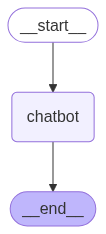

In [4]:
# entry point to start the work
graph_builder.add_edge(START, "chatbot")

# exit point for more clarity
graph_builder.add_edge("chatbot", END)


#compile and visualize
graph = graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: **Hi** is an informal greeting commonly used in English, typically among people who know each other. It is considered more casual than "hello" and is often used in everyday situations to acknowledge someone or start a conversation[1][5]. The pronunciation is /haɪ/[1]. 

In other contexts, "hi" can have different meanings. For example, in Basque, "hi" is an informal pronoun used between close friends or family members, with specific grammatical rules for its use[2].
Assistant: LangGraph is a **framework for building agentic and multi-agent applications** powered by large language models (LLMs)[1][2][3][4]. It is part of the LangChain ecosystem but can be used independently. LangGraph enables developers to design, coordinate, and execute workflows where AI agents—or multiple collaborating agents—can perform complex tasks such as answering emails, managing schedules, analyzing data, or providing customer support[1][4].

Key features of LangGraph include:

- **Agentic Capabiliti

# Adding tools like web search

In [22]:
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = settings.TAVILY_API_KEY
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5',
   'title': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges',
   'content': 'Nodes: Perform the actual work. Nodes contain Python code that can execute any logic, from simple computations to LLM calls or integrations.',
   'score': 0.79254496,
   'raw_content': None},
  {'url': 'https://blog.langchain.dev/langgraph/',
   'title': 'LangGraph - LangChain Blog',
   'content': "TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent 

In [9]:
llm_with_tools = llm.bind_tools(tools)
def chatbot_withSearch(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# pERPlexity doesnt support tool calling :(

NameError: name 'tools' is not defined

In [6]:
from langchain.tools import tool

@tool
def search_web(query: str) -> str:
    '''Example stub for search'''
    return f"Search results for '{query}'"

# create tool node and appedn to messages
def tool_node(state: dict) -> dict:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}

In [8]:
# conditional routing based on if web search is necessary (told by our llm)
def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_node("tools", tool_node)
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

graph = graph_builder.compile()


Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


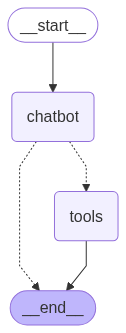

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# adding in-memory

In [11]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [13]:
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Sanjiv."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi there! My name is Sanjiv.
================================== Ai Message ==================================

Hello Sanjiv! How can I assist you today? If you have any questions or need help with something, feel free to let me know.


In [14]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember that your name is **Sanjiv**. Remembering user names helps create a more personalized and engaging conversation, just as personalization features in AI assistants are designed to recall details like names and preferences across interactions[2][4]. If you’d like me to remember anything else or use your name in our future conversations, just let me know!


In [15]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Sanjiv.', additional_kwargs={}, response_metadata={}, id='4d510145-9164-4c8b-9213-44074442f1ca'), AIMessage(content='Hello Sanjiv! How can I assist you today? If you have any questions or need help with something, feel free to let me know.', additional_kwargs={'citations': ['https://www.youtube.com/channel/UCVoj1HOaUlq2hw9uBHwwHVg', 'https://www.instagram.com/p/Cvf_SJItEax/', 'https://shirtscope.com/gshirts.php?id=318421', 'https://www.youtube.com/watch?v=kezxh40pkoc', 'https://support.google.com/accounts/thread/135348249/hello-sir-my-name-is-sanjeev-verma-and-someone-hacked-my-gmail-account-please-help-me-to-get-back']}, response_metadata={'model_name': 'sonar-pro'}, id='run--4ccb4162-09eb-4c29-b134-12b84bef7662-0', usage_metadata={'input_tokens': 10, 'output_tokens': 30, 'total_tokens': 40}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='b9b12d39-28f1-472d-860c-00